In [1]:
import numpy as np
import os
import cv2
import pytesseract
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx

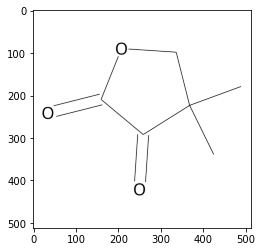

In [104]:
def create_filename(num: int) -> str:
    return str(num) + '.png'

FOLDER_NAME = '../images'

img_num = 29

img = cv2.imread(
    #'images/vanilin.png',
    os.path.join(FOLDER_NAME, create_filename(img_num)),
    cv2.IMREAD_GRAYSCALE
)
img = cv2.bitwise_not(img)

plt.imshow(img, cmap='Greys')
plt.show()
dst = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dst = cv2.bitwise_not(dst)
#dst = cv2.Canny(img, 50, 200, None, 3)
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)


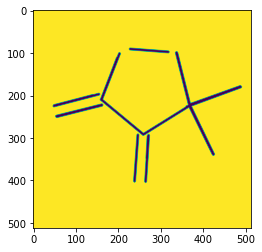

In [105]:
lines = cv2.HoughLinesP(image=dst, 
                        rho=1, 
                        theta=(np.pi / 180),
                        threshold=50,
                        lines=None,
                        minLineLength=45,
                        maxLineGap=5
)
new_one = np.zeros([512, 512, 1], dtype=np.uint8)
new_one.fill(255)
for lin in lines:
    l = lin[0]
    cv2.line(new_one, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv2.LINE_AA)
plt.imshow(new_one)
plt.show()

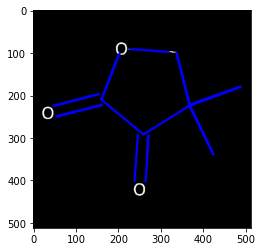

In [106]:
for lin in lines:
    l = lin[0]
    cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv2.LINE_AA)
plt.imshow(cdst)
plt.show()

In [ ]:
    
#"""
def get_length(line):
    return np.sqrt((line[0] - line[2]) ** 2 + (line[1] - line[3]) ** 2)

def close_dotes(fst, snd, threshold=25):
    return (fst[0] - snd[0]) ** 2 + (fst[1] - snd[1]) ** 2 <= threshold

def filter_lines(lines):
    to_del = set()
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            start_i = (lines[i][0], lines[i][1])
            end_i = (lines[i][2], lines[i][3])
            start_j = (lines[j][0], lines[j][1])
            end_j = (lines[j][2], lines[j][3])
            if close_dotes(start_i, start_j) and close_dotes(end_i, end_j):
                to_del.add(j)
    return np.array([lines[i] for i in range(len(lines)) if i not in to_del])

def calculate_theta(line):
    if line[2] == line[0]:
        return np.pi / 2
    return np.arctan((line[3] - line[1]) / (line[2] - line[0]))

def get_new_line(start1, end1, start2, end2):
    lines = [[start1[0], start1[1], start2[0], start2[1]],
             [start1[0], start1[1], end2[0], end2[1]],
             [end1[0], end1[1], start2[0], start2[1]],
             [end1[0], end1[1], end2[0], end2[1]]]
    lengths = list(map(get_length, lines))
    lengths = np.array(lengths)
    j = np.argmax(lengths)
    return lines[j]

def conj_lines(fst, snd):
    th1 = calculate_theta(fst[0])
    th2 = calculate_theta(snd[0])
    if abs(th1 - th2) > 0.1:
        return [fst, snd]
    start1 = [fst[0][0], fst[0][1]]
    end1 = [fst[0][2], fst[0][3]]
    start2 = [snd[0][0], snd[0][1]]
    end2 = [snd[0][2], snd[0][3]]
    for i in range(0, 21):
        med = [(start1[0] * i + end1[0] * (20 - i)) / 20, (start1[1] * i + end1[1] * (20 - i)) / 20]
        if close_dotes(med, start2) or close_dotes(med, end2):
            new_start = (start2 if (get_length([start1[0], start1[1], start2[0], start2[1]]) >
                                    get_length([start1[0], start1[1], end2[0], end2[1]])) else end2)
            return [[np.array(get_new_line(start1, end1, start2, end2)), False], None]
    return [fst, snd]

def check_if_ready(set_of_lines):
    for line in set_of_lines:
        if not line[1]:
            return False
    return True

def continue_lines(lines, threshold=25):
    conj = [[line, False] for line in lines]
    while not check_if_ready(conj):
        fst = None
        while conj[0][1]:
            tmp = conj.pop(0)
            conj.append(tmp)
        fst = conj.pop(0)
        cnt = len(conj)
        while cnt > 0:
            cnt -= 1
            snd = conj.pop(0)
            if snd[1]:
                conj.append(snd)
                continue
            fst, snd = conj_lines(fst, snd)
            if snd is not None:
                conj.append(snd)
        fst[1] = True
        conj.append(fst)
    return np.array([line[0] for line in conj])

groups = []
legal_groups = {'OH': 'OH', 'HO': 'OH', 'HO:': 'OH', 'HQ': 'OH', 'Cl': 'Cl'}
data = pytesseract.image_to_data(cdst, output_type=pytesseract.Output.DICT)
for i, _ in enumerate(data['text']):
    if data['text'][i] in legal_groups.keys():
        width = data['width'][i]
        height = data['height'][i]
        top = data['top'][i]
        left = data['left'][i]
        #print(data['text'][i])

        tl = (left, top)
        tr = (left + width, top)
        bl = (left, top + height)
        br = (left + width, top + height)
        
        groups.append([(tl, br), legal_groups[data['text'][i]]])

        cdst = cv2.rectangle(cdst, tl, br, (0, 0, 0), -1)
    
lines = cv2.HoughLinesP(image=dst, 
                        rho=1, 
                        theta=(np.pi / 180),
                        threshold=60,
                        lines=None,
                        minLineLength=1,
                        maxLineGap=5
)
ok_lines = np.array([line[0] for line in lines if get_length(line[0]) > 50])
ok_lines = filter_lines(ok_lines)
ok_lines = continue_lines(ok_lines)
for l in ok_lines:
    cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0, 0, 0), 3, cv2.LINE_AA)
"""
string = pytesseract.image_to_string(cdst)
print(string)
"""
data = pytesseract.image_to_data(cdst, output_type=pytesseract.Output.DICT)
for i, _ in enumerate(data['text']):
    if data['text'][i] in legal_groups:
        width = data['width'][i]
        height = data['height'][i]
        top = data['top'][i]
        left = data['left'][i]
        #print(data['text'][i])

        tl = (left, top)
        tr = (left + width, top)
        bl = (left, top + height)
        br = (left + width, top + height)
        
        groups.append([(tl, br), data['text'][i]])

        cdst = cv2.rectangle(cdst, tl, br, (0, 0, 0), -1)
"""
data = pytesseract.image_to_data(cdst, output_type=pytesseract.Output.DICT)
for i, _ in enumerate(data['text']):
    width = data['width'][i]
    height = data['height'][i]
    top = data['top'][i]
    left = data['left'][i]
    
    tl = (left, top)
    tr = (left + width, top)
    bl = (left, top + height)
    br = (left + width, top + height)

    cdst = cv2.line(cdst, tl, tr, (255, 0, 0), 2)
    cdst = cv2.line(cdst, tr, br, (255, 0, 0), 2)
    cdst = cv2.line(cdst, br, bl, (255, 0, 0), 2)
    cdst = cv2.line(cdst, bl, tl, (255, 0, 0), 2)
"""
"""
letters, hih = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
for i, letter in enumerate(letters):
    (width, height, top, left) = cv2.boundingRect(letter)
    
    tl = (left, top)
    br = (left + width, top + height)
    
    if hih[0][i][3] == 0:
        cdst2 = cv2.rectangle(cdst2, tl, br, (0, 0, 255), 1)
"""


print(ok_lines)
print(ok_lines.shape)
print(groups)
plt.imshow(cdst)
#croped_image = cdst[90:150, 130:180]
#print(pytesseract.image_to_string(croped_image))
#plt.imshow(cdst)
plt.show()

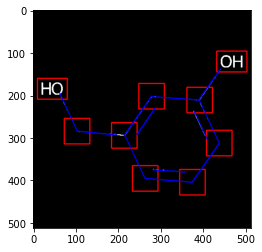

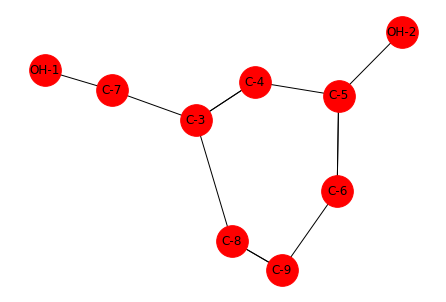

In [3]:
def in_rect(dot, rect):
    return (rect[0][0] <= dot[0] <= rect[1][0]) and (rect[0][1] <= dot[1] <= rect[1][1])

def make_graph(lines, groups, cdst, threshold=25, bound=30):
    graph = nx.MultiGraph()
    node_id = 0
    node_pos = {}
    # make nodes from groups
    delta = 10
    for group in groups:
        node_id += 1
        node_name = group[1] + '-' + str(node_id)
        graph.add_node(node_name)
        node_pos[node_name] = ((max(0, group[0][0][0] - delta), max(0, group[0][0][1] - delta)),
                               (min(512, group[0][1][0] + delta), min(512, group[0][1][1] + delta)))
    # make nodes from intersections
    for i, line in enumerate(lines):
        fst_end = (line[0], line[1])
        snd_end = (line[2], line[3])
        fst_connected = False
        snd_connected = False
        for key, value in node_pos.items():
            fst_connected |= in_rect(fst_end, value)
            snd_connected |= in_rect(snd_end, value)
        #print(f'{fst_connected}, {snd_connected}')
        if not fst_connected:
            done_fst = False
            for j in range(i + 1, len(lines)):
                if (close_dotes(fst_end, (lines[j][0], lines[j][1]), threshold) or 
                    close_dotes(fst_end, (lines[j][2], lines[j][3]), threshold)):
                    node_id += 1
                    node_name = 'C-' + str(node_id)
                    graph.add_node(node_name)
                    node_pos[node_name] = ((max(0, fst_end[0] - bound), max(0, fst_end[1] - bound)),
                                           (min(512, fst_end[0] + bound), min(512, fst_end[1] + bound)))
                    done_fst = True
                    break
            if not done_fst:
                node_id += 1
                node_name = 'C-' + str(node_id)
                graph.add_node(node_name)
                node_pos[node_name] = ((max(0, fst_end[0] - bound), max(0, fst_end[1] - bound)),
                                       (min(512, fst_end[0] + bound), min(512, fst_end[1] + bound)))
        if not snd_connected:
            done_snd = False
            for j in range(i + 1, len(lines)):
                if (close_dotes(snd_end, (lines[j][0], lines[j][1]), threshold) or 
                    close_dotes(snd_end, (lines[j][2], lines[j][3]), threshold)):
                    node_id += 1
                    node_name = 'C-' + str(node_id)
                    graph.add_node(node_name)
                    node_pos[node_name] = ((max(0, snd_end[0] - bound), max(0, snd_end[1] - bound)),
                                           (min(512, snd_end[0] + bound), min(512, snd_end[1] + bound)))
                    done_snd = True
                    break
            if not done_snd:
                node_id += 1
                node_name = 'C-' + str(node_id)
                graph.add_node(node_name)
                node_pos[node_name] = ((max(0, snd_end[0] - bound), max(0, snd_end[1] - bound)),
                                       (min(512, snd_end[0] + bound), min(512, snd_end[1] + bound)))
    # connect nodes
    for line in lines:
        fst_end = (line[0], line[1])
        snd_end = (line[2], line[3])
        fst_node = None
        snd_node = None
        for key, value in node_pos.items():
            if in_rect(fst_end, value):
                fst_node = key
                break
        for key, value in node_pos.items():
            if in_rect(snd_end, value):
                snd_node = key
                break
        if (fst_node is not None) and (snd_node is not None):
            graph.add_edge(fst_node, snd_node)
    
    for value in node_pos.values():
        cdst = cv2.rectangle(cdst, value[0], value[1], (255, 0, 0), 2)
    
    for line in lines:
        cdst = cv2.line(cdst, (line[0], line[1]), (line[2], line[3]), (0, 0, 255), 2)
    
    return (graph, cdst)

img2 = cv2.imread(
    #'images/vanilin.png',
    os.path.join(FOLDER_NAME, create_filename(img_num)),
    cv2.IMREAD_GRAYSCALE
)
dst2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
dst2 = cv2.bitwise_not(dst2)
cdst2 = cv2.cvtColor(dst2, cv2.COLOR_GRAY2BGR)

graph, cdst2 = make_graph(ok_lines, groups, cdst2, threshold=100)
plt.imshow(cdst2)
plt.show()
nx.draw(graph, node_color='red', node_size=1000, with_labels=True)

In [ ]:
print(graph.degree['OH-1'])
#print(graph.nodes)
#print(graph.edges)
print(len(graph.adj['C-5']))

In [4]:
class GraphToSmiles:
    def __init__(self, graph):
        self._graph = graph
        self._was = {node: False for node in graph.nodes}
        self._breaks = {node: [] for node in graph.nodes}
        self._deleted_edges = set()
        self._rank = {}
        self._break = 0
        self._typing = {'OH': 'O', 'NH': 'N', 'C': 'C', 'Cl': 'Cl'}
        self._tree = {node: [] for node in graph.nodes}
        self._root = None
        
    def get_type(self, node):
        return self._typing[node[:node.find('-')]]
    
    def add_break(self, nodes):
        self._break += 1
        self._deleted_edges.add(nodes)
        self._deleted_edges.add((nodes[1], nodes[0]))
        for node in nodes:
            self._breaks[node].append(str(self._break))
    
    def dfs(self, node, prev):
        self._was[node] = True
        neighb = [v for v in self._graph.neighbors(node)]
        if prev is not None:
            neighb.remove(prev)
        sorted(neighb, key=lambda v: self._rank[v])
        for i, child in enumerate(neighb):
            if len(self._graph.get_edge_data(node, child)) == 2:
                adj = '='
            elif len(self._graph.get_edge_data(node, child)) == 3:
                adj = '#'
            else:
                adj = ''
            if self._was[child]:
                if (node, child) not in self._deleted_edges:
                    self.add_break((node, child))
            else:
                self._tree[node].append((adj, child))
                self.dfs(child, node)
    
    def morgan_algo(self):
        ec = {v: len(self._graph.adj[v]) for v in self._graph.nodes}
        prev_k = 0
        k = len(set(ec.values()))
        while prev_k < k and k < len(self._graph.nodes):
            new_ec = {}
            for v in ec.keys():
                new_ec[v] = 0
                for u in self._graph.neighbors(v):
                    new_ec[v] += ec[u]
            prev_k = k
            k = len(set(new_ec.values()))
            if prev_k < k:
                ec = new_ec
        ranks = ec.items()
        sorted(ranks, key=lambda item: item[1])
        cnt = 0
        for rank in ranks:
            cnt += 1
            self._rank[rank[0]] = cnt
    
    def build_smiles(self, node):
        accum = ''
        left = '('
        right = ')'
        for i, u in enumerate(self._tree[node]):
            if i + 1 == len(self._tree[node]):
                left = ''
                right = ''
            accum += left + u[0] + self.build_smiles(u[1]) + right
        return self.get_type(node) + ''.join(self._breaks[node]) + accum
    
    def get_smiles(self):
        for node in self._graph.nodes:
            if self.get_type(node) == 'C':
                self._root = node
                break
        self.morgan_algo()
        self.dfs(self._root, None)
        #print(self._root)
        #print(self._tree)
        return self.build_smiles(self._root)

GTS = GraphToSmiles(graph)
print(GTS.get_smiles())

C1(=CC(=CC=C1)O)CO
